In [1]:
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = (6, 6)

import math
import cmath          # math functions for complex numbers
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

import scipy
import scipy.stats
import pandas as pd

from astropy.io import fits
import os.path

import ipywidgets
from ipywidgets import interact

import sys
sys.path.append("/Users/jdecock/git/pub/jdhp-sap/sap-cta-data-pipeline/datapipe")
import datapipe
import datapipe.denoising.wavelets_mrfilter as mrfilter
sys.path.append("/Users/jdecock/git/pub/jdhp-sap/sap-cta-data-pipeline/utils")
import common_functions as common

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/PIL/Image.py:85: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/PIL/Image.py:85: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/pytz/__init__.py:29: UserWarning: Module argparse was already imported from /Users/jdecock/anaconda/envs/cta/lib/python3.5/argparse.py, but /Users/jdecock/.local/lib/python3.5/site-packages/argparse-1.1-py3.5.egg is being added to sys.path
  from pkg_resources import resource_stream
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/PIL/Image.py:85: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)


## Search for good images

In [2]:
CSV_FILE_PATH = "xps/2017_02_22/2017_02_20-22.csv"
WAVELET_LABEL = "Wavelets-n4-K-k-C1-s3-m3-kill"
#WAVELET_LABEL = "WT-ref-f3-s3"

#CSV_FILE_PATH = "xps/2017_02_22_sapcta/2017_02_22_sapcta_best.csv"
#WAVELET_LABEL = "WT-t24-f3-s4"

#CSV_FILE_PATH = "xps/2017_02_23_sapcta/2017_02_23_sapcta.csv"
#WAVELET_LABEL = "WT-ref-s2-2-3-3"


TAILCUT_LABEL = "Tailcut-5-10-kill"

PART = 0         # 0 for gamma, 1 for protons

XLINE = 100

df = pd.read_csv(CSV_FILE_PATH)

df.columns

Index(['Part', 'Id', 'Evt', 'Tel', 'Exect', 'Xtel', 'Ytel', 'Ztel', 'E',
       'Theta', 'Phi', 'X', 'Y', 'Z', 'peSum', 'Type', 'Success', 'hX', 'hY',
       'hLength', 'hWidth', 'hSize', 'hPsi', 'hSkew', 'hCurt', 'hDist',
       'border', 'peMax1', 'peMin', 'nPix', 'Dshape', 'Denergy'],
      dtype='object')

In [23]:
ref = df[df.Type == 'Ref']
ref = ref[ref.Part == PART]

tc = df[df.Type == TAILCUT_LABEL]
tc = tc[tc.Part == PART]

wt = df[df.Type == WAVELET_LABEL]
wt = wt[wt.Part == PART]

tc_wt = pd.merge(tc, wt, on="Id", suffixes=('_tc', '_wt'))  #.dropna(how='any')
ref_tc_wt = pd.merge(tc_wt, ref, on="Id")

ref_tc_wt["delta_tc"] = np.fmod(((ref_tc_wt['hPsi'] - ref_tc_wt['hPsi_tc']) * 180. / np.pi), 90.)
ref_tc_wt["delta_wt"] = np.fmod(((ref_tc_wt['hPsi'] - ref_tc_wt['hPsi_wt']) * 180. / np.pi), 90.)

ref_tc_wt.delta_tc = abs(ref_tc_wt.delta_tc)
ref_tc_wt.delta_wt = abs(ref_tc_wt.delta_wt)

#selection = ref_tc_wt[ref_tc_wt.peSum_tc > 50][ref_tc_wt.peSum_tc < 200][ref_tc_wt.nPix_tc > 17][ref_tc_wt.delta_tc > 1.][ref_tc_wt.delta_wt < 1.].loc[:,['Id','Tel','Evt','delta_tc','delta_wt']]
selection = ref_tc_wt[ref_tc_wt.peSum_tc > 50][ref_tc_wt.peSum_tc < 200][ref_tc_wt.nPix_tc > 10][ref_tc_wt.delta_tc > 5.][ref_tc_wt.delta_wt < 1.].loc[:,['Id','Tel','Evt','delta_tc','delta_wt']]
print("Search:", len(selection))
print("Search:", selection)

file_path_list = []
for tel, ev in zip(selection.Tel.values, selection.Evt.values):
    path = "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL{:03d}_EV{}.fits".format(tel, ev)
    file_path_list.append(path)

print(file_path_list)

Search: 22
Search:               Id  Tel     Evt   delta_tc  delta_wt
60      144509_1    1  144509   5.666723  0.965253
480       6301_2    2    6301   6.764410  0.884524
815     427406_2    2  427406  18.941569  0.022770
2085    285101_5    5  285101   6.916984  0.586055
2755    443303_6    6  443303  12.535427  0.027138
3322     88507_7    7   88507   6.834796  0.045530
4924   216502_11   11  216502  87.413808  0.097792
5220    62605_11   11   62605   5.285214  0.947314
6024   400909_13   13  400909   6.384182  0.360166
6543   442506_14   14  442506   5.727756  0.191244
7260   225003_16   16  225003   5.061315  0.586633
8056    76100_17   17   76100   5.596371  0.679857
9197    30404_20   20   30404   7.275595  0.336019
9651   339509_21   21  339509   9.524492  0.776600
11626  483103_25   25  483103   5.853889  0.678608
12033   78402_26   26   78402  86.456935  0.016050
12074  114604_27   27  114604   5.978813  0.176426
13276  103604_30   30  103604   8.023647  0.805575
13374  20070

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


## GUI

In [5]:
# gamma 10000 - 50000 (electronic saturation!)
file_path_list = [
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL033_EV131901.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL012_EV131903.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL030_EV131907.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL030_EV131908.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL031_EV311808.fits"
    ]

In [6]:
# gamma 1000 - 10000
file_path_list = [
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV126402.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV131305.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV182506.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV225002.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV26603.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV458108.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV483109.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV62605.fits"
    ]

In [7]:
# gamma 50 - 1000

file_path_list = [
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV155601.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV193406.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV347307.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV427404.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV450207.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV454807.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV48104.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV58000.fits"
    ]

In [20]:
# mr_filter options

option_list = [
    "-K -C1 -m3  -s4 -n4 -t24 -f3",           # Suggested by Jean-Luc (TODO: try to adapt -s)
#    "-K -C1 -m3  -s5 -n4 -t28 -f3 -i10 -e0",  # Suggested by Jean-Luc (TODO: try to adapt -s)
    "-K -C1 -m3  -s3 -n4",      # Hard K-Sigma Thresholding, Poisson + Gaussian
    "-K -C1 -m3  -s3 -n4 -f3",
#    "-K -C1 -m3  -s2,2,3,3 -n4 -f3",
    "-K -C1 -m3  -s2,2,3,3 -n4",
#    "-K -C1 -m3  -s3 -n4 -f2",  # Soft K-Sigma Thresholding, Poisson + Gaussian (deconseille par JL)
#    "-K -C2 -m1      -n4 -f2",  # False Discovery Rate
#    "-K     -m1      -n4 -f6",  # Wiener Filtering (min MSE between random process and desired process)
#    "-K -C1 -m10 -s3 -n4",      # Poisson with few events
#    "-K -C1 -m2  -s3 -n4",      # Poisson
    ]


mr_filter -K -C1 -m3  -s4 -n4 -t24 -f3 ".tmp_93878_1488227664.775317_in.fits" .tmp_93878_1488227664.775326_out.fits
Kill isolated pixels


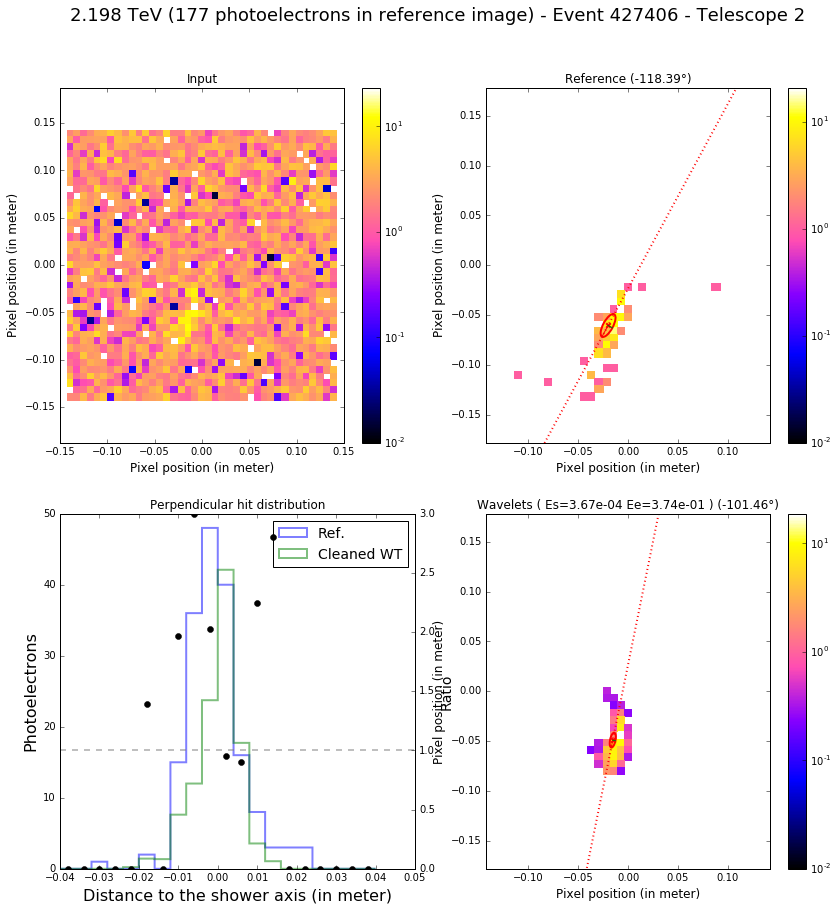

In [24]:
@interact(kill_pix=True, hist=False, log_scale=True, ellipses=True, lateral_hst=["Wavelet", "Tailcut", None], ref_angle=False, file_path=file_path_list, mrfilter=option_list)
def gui(kill_pix, hist, log_scale, ellipses, lateral_hst, ref_angle, file_path, mrfilter):
    fits_images_dict, fits_metadata_dict = datapipe.io.images.load_benchmark_images(file_path)
    input_img = fits_images_dict["input_image"]
    reference_img = fits_images_dict["reference_image"]
    pixels_position = fits_images_dict["pixels_position"]

    fig = plt.figure(figsize=(14, 14))

    common.plot_gui(fig,
                    input_img,
                    reference_img,
                    pixels_position,
                    fits_metadata_dict,
                    wavelets_cmd=mrfilter,
                    kill_isolated_pixels=kill_pix,
                    plot_histogram=hist,
                    plot_log_scale=log_scale,
                    plot_ellipse_shower=ellipses,
                    _plot_perpendicular_hit_distribution=lateral_hst,  # None, "Tailcut", "Wavelet"
                    use_ref_angle_for_perpendicular_hit_distribution=ref_angle,
                    notebook=True
                   )